# OPERA RTC-S1 Coefficient of Variation: User Supplied Dataset Notebook

![SAR, InSAR, PolSAR, and banner](https://opensarlab-docs.asf.alaska.edu/opensarlab-notebook-assets/notebook_images/blackboard-banner.png)

### Franz J Meyer; University of Alaska Fairbanks, Josef Kellndorfer, [Earth Big Data, LLC](http://earthbigdata.com/), & Alex Lewandowski; University of Alaska Fairbanks

<img src="https://opensarlab-docs.asf.alaska.edu/opensarlab-notebook-assets/notebook_images/UAFLogo_A_647.png" width="170" align="right" />

This notebook will introduce you to the analysis of multi-temporal SAR image data stacks.

**We introduce the following data analysis concepts:**

- How to load your previously downloaded OPERA RTCs and create a time series stack 
- How to create a time series of your data.
- How to calculate a Coefficient of Variation
- How to threshold the Coefficient of Variation

---
**Important Note about JupyterHub**

Your JupyterHub server will automatically shutdown when left idle for more than 1 hour. Your notebooks will not be lost but you will have to restart their kernels and re-run them from the beginning. You will not be able to seamlessly continue running a partially run notebook.

In [1]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

URLWidget()

In [2]:
from IPython.display import Markdown
from IPython.display import display

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX
if env[0] == '':
    env[0] = 'Python 3 (base)'
if env[0] != '/home/jovyan/.local/envs/NISAR_EA_Workshop_2024_1':
    display(Markdown(f'<text style=color:red><strong>WARNING:</strong></text>'))
    display(Markdown(f'<text style=color:red>This notebook should be run using the "NISAR_EA_Workshop_2024_1" conda environment.</text>'))
    display(Markdown(f'<text style=color:red>It is currently using the "{env[0].split("/")[-1]}" environment.</text>'))
    display(Markdown(f'<text style=color:red>Select the "NISAR_EA_Workshop_2024_1" from the "Change Kernel" submenu of the "Kernel" menu.</text>'))

---
## 0. Importing Relevant Python Packages

In this notebook we will use the following scientific libraries:

- [Pandas](https://pandas.pydata.org/) is a Python library that provides high-level data structures and a vast variety of tools for analysis. The great feature of this package is the ability to translate rather complex operations with data into one or two commands. Pandas contains many built-in methods for filtering and combining data, as well as the time-series functionality.
- [GDAL](https://www.gdal.org/) is a software library for reading and writing raster and vector geospatial data formats. It includes a collection of programs tailored for geospatial data processing. Most modern GIS systems (such as ArcGIS or QGIS) use GDAL in the background.
- [NumPy](http://www.numpy.org/) is one of the principal packages for scientific applications of Python. It is intended for processing large multidimensional arrays and matrices, and an extensive collection of high-level mathematical functions and implemented methods makes it possible to perform various operations with these objects. 
- [Matplotlib](https://matplotlib.org/index.html) is a low-level library for creating two-dimensional diagrams and graphs. With its help, you can build diverse charts, from histograms and scatterplots to non-Cartesian coordinates graphs. Moreover, many popular plotting libraries are designed to work in conjunction with matplotlib.
- [SciPy](https://www.scipy.org/about.html) is a library that provides functions for numerical integration, interpolation, optimization, linear algebra and statistics.

**Import packages:**

In [3]:
%%capture
import re
from pathlib import Path
import h5py
import math # for ceil

import pandas as pd # for DatetimeIndex
from osgeo import gdal # for Info
gdal.UseExceptions()
import numpy as np # for copy, isnan, log10, ma.masked_where, max, mean, min, percentile, power, unique, var, where 
import scipy.signal

%matplotlib inline
import matplotlib.pylab as plb # for figure, grid, rcParams, savefig
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import rc

from ipyfilechooser import FileChooser

from IPython.display import HTML

import opensarlab_lib as asfn

---
## 1. Load Your Prepared Data Stack Into the Notebook

**Select the directory holding your tiffs**
- Click the `Select` button
- Navigate to the directory holding your OPERA S1-RTCs
- Click the `Select` button
- Confirm that the desired path appears in green text
- Click the `Change` button to alter your selection

In [4]:
fc = FileChooser(Path.home())
display(fc)

FileChooser(path='/home/jovyan', filename='', title='', show_hidden=False, select_desc='Select', change_desc='…

**Select a polarization:**

In [7]:
polarization_select = asfn.select_parameter(['VH', 'VV'])
display(polarization_select)

RadioButtons(layout=Layout(min_width='800px'), options=('VH', 'VV'), value='VH')

**Gather the paths to the tiffs and h5 file containing the metadata**

In [8]:
polar = polarization_select.value
analysis_dir = Path(fc.selected_path)
tiff_paths = list(analysis_dir.glob(f"*/*{polar}.tif"))
hdf5_paths = list(analysis_dir.glob("*/*.h5"))
hdf5_paths.sort()
tiff_paths.sort()
tiff_paths

[PosixPath('/home/jovyan/Workshop_Jupyter_Books/Gazipur_BD_demo/T114_242855_IW2/OPERA_L2_RTC-S1_T114-242855-IW2_20231014T120514Z_20231015T005157Z_S1A_30_v1.0/OPERA_L2_RTC-S1_T114-242855-IW2_20231014T120514Z_20231015T005157Z_S1A_30_v1.0_VV.tif'),
 PosixPath('/home/jovyan/Workshop_Jupyter_Books/Gazipur_BD_demo/T114_242855_IW2/OPERA_L2_RTC-S1_T114-242855-IW2_20231026T120514Z_20231027T074658Z_S1A_30_v1.0/OPERA_L2_RTC-S1_T114-242855-IW2_20231026T120514Z_20231027T074658Z_S1A_30_v1.0_VV.tif'),
 PosixPath('/home/jovyan/Workshop_Jupyter_Books/Gazipur_BD_demo/T114_242855_IW2/OPERA_L2_RTC-S1_T114-242855-IW2_20231107T120513Z_20231111T124757Z_S1A_30_v1.0/OPERA_L2_RTC-S1_T114-242855-IW2_20231107T120513Z_20231111T124757Z_S1A_30_v1.0_VV.tif'),
 PosixPath('/home/jovyan/Workshop_Jupyter_Books/Gazipur_BD_demo/T114_242855_IW2/OPERA_L2_RTC-S1_T114-242855-IW2_20231119T120513Z_20231120T014434Z_S1A_30_v1.0/OPERA_L2_RTC-S1_T114-242855-IW2_20231119T120513Z_20231120T014434Z_S1A_30_v1.0_VV.tif'),
 PosixPath('/hom

In [9]:
hdf5_paths

[PosixPath('/home/jovyan/Workshop_Jupyter_Books/Gazipur_BD_demo/T114_242855_IW2/OPERA_L2_RTC-S1_T114-242855-IW2_20231014T120514Z_20231015T005157Z_S1A_30_v1.0/OPERA_L2_RTC-S1_T114-242855-IW2_20231014T120514Z_20231015T005157Z_S1A_30_v1.0.h5'),
 PosixPath('/home/jovyan/Workshop_Jupyter_Books/Gazipur_BD_demo/T114_242855_IW2/OPERA_L2_RTC-S1_T114-242855-IW2_20231026T120514Z_20231027T074658Z_S1A_30_v1.0/OPERA_L2_RTC-S1_T114-242855-IW2_20231026T120514Z_20231027T074658Z_S1A_30_v1.0.h5'),
 PosixPath('/home/jovyan/Workshop_Jupyter_Books/Gazipur_BD_demo/T114_242855_IW2/OPERA_L2_RTC-S1_T114-242855-IW2_20231107T120513Z_20231111T124757Z_S1A_30_v1.0/OPERA_L2_RTC-S1_T114-242855-IW2_20231107T120513Z_20231111T124757Z_S1A_30_v1.0.h5'),
 PosixPath('/home/jovyan/Workshop_Jupyter_Books/Gazipur_BD_demo/T114_242855_IW2/OPERA_L2_RTC-S1_T114-242855-IW2_20231119T120513Z_20231120T014434Z_S1A_30_v1.0/OPERA_L2_RTC-S1_T114-242855-IW2_20231119T120513Z_20231120T014434Z_S1A_30_v1.0.h5'),
 PosixPath('/home/jovyan/Worksho

**Collect the product acquisition dates:**

In [10]:
acquisition_date_regex = r"(?<=OPERA_L2_RTC-S1_T\d{3}-\d{6}-IW\d_)\d{8}T\d{6}Z(?=_\d{8}T\d{6}Z)"
try:
    dates = [re.search(acquisition_date_regex, str(tiff)).group(0) for tiff in tiff_paths]
    dates.sort()
except:
    raise
print(dates)

['20231014T120514Z', '20231026T120514Z', '20231107T120513Z', '20231119T120513Z', '20231201T120513Z', '20231213T120512Z', '20231225T120511Z', '20240106T120511Z', '20240118T120510Z', '20240130T120510Z']


**Organize stack path information into a Pandas DataFrame**

In [11]:
stack_meta = pd.DataFrame()
stack_meta['image_path'] = [str(t) for t in tiff_paths]
stack_meta['metadata_path'] = [str(t) for t in hdf5_paths]
stack_meta['product_id'] = [t.parent.name for t in tiff_paths]
stack_meta['acquisition_date'] = pd.DatetimeIndex(dates)
stack_meta

image_path  \
0  /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD...   
1  /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD...   
2  /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD...   
3  /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD...   
4  /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD...   
5  /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD...   
6  /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD...   
7  /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD...   
8  /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD...   
9  /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD...   

                                       metadata_path  \
0  /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD...   
1  /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD...   
2  /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD...   
3  /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD...   
4  /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD...   
5  /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD...   
6  /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD...   
7  /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD...   
8  /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD...   
9  /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD...   

                                          product_id          acquisition_date  
0  OPERA_L2_RTC-S1_T114-242855-IW2_20231014T12051... 2023-10-14 12:05:14+00:00  
1  OPERA_L2_RTC-S1_T114-242855-IW2_20231026T12051... 2023-10-26 12:05:14+00:00  
2  OPERA_L2_RTC-S1_T114-242855-IW2_20231107T12051... 2023-11-07 12:05:13+00:00  
3  OPERA_L2_RTC-S1_T114-242855-IW2_20231119T12051... 2023-11-19 12:05:13+00:00  
4  OPERA_L2_RTC-S1_T114-242855-IW2_20231201T12051... 2023-12-01 12:05:13+00:00  
5  OPERA_L2_RTC-S1_T114-242855-IW2_20231213T12051... 2023-12-13 12:05:12+00:00  
6  OPERA_L2_RTC-S1_T114-242855-IW2_20231225T12051... 2023-12-25 12:05:11+00:00  
7  OPERA_L2_RTC-S1_T114-242855-IW2_20240106T12051... 2024-01-06 12:05:11+00:00  
8  OPERA_L2_RTC-S1_T114-242855-IW2_20240118T12051... 2024-01-18 12:05:10+00:00  
9  OPERA_L2_RTC-S1_T114-242855-IW2_20240130T12051... 2024-01-30 12:05:10+00:00

**Determine the projection and extents of the stack**

In [12]:
with h5py.File(stack_meta['metadata_path'][0], 'r') as h5:
    bbox = h5['identification/boundingBox'][:]
    projection = h5['data/projection'][()].astype(str)
extents = [[bbox[0], bbox[3]], [bbox[2], bbox[1]]]
print(f'extents: {extents}')
print(f'projection: {projection}')

extents: [[176040.0, 2698860.0], [279090.0, 2653050.0]]
projection: 32646


---
Now we stack up the data by creating a virtual raster table with links to all subset data files:

**Create the virtual raster table for the subset GeoTiffs:**

In [13]:
vrt_path = Path(f"{analysis_dir}/raster_stack.vrt")
!gdalbuildvrt -separate $vrt_path {' '.join([str(p) for p in stack_meta['image_path']])}

0...10...20...30...40...50...60...70...80...90...100 - done.


---
## 3. Now You Can Work With Your Data

Now you are ready to perform time series analysis on your data stack

**Print the bands and dates for all images in the virtual raster table (VRT):**

In [14]:
j = 1
print(f"Bands and dates for {vrt_path}")
for i in stack_meta['acquisition_date']:
    print("{:4d} {}".format(j, i.date()), end=' ')
    j += 1
    if j%5 == 1:
        print()

Bands and dates for /home/jovyan/Workshop_Jupyter_Books/Gazipur_BD_demo/T114_242855_IW2/raster_stack.vrt
   1 2023-10-14    2 2023-10-26    3 2023-11-07    4 2023-11-19    5 2023-12-01 
   6 2023-12-13    7 2023-12-25    8 2024-01-06    9 2024-01-18   10 2024-01-30 


---
## 3.2 Open Your Data Stack and Visualize Some Layers

We will **open your VRT** and visualize some layers using Matplotlib.

In [15]:
img = gdal.Open(str(vrt_path))

**Print the bands, pixels, and lines:**

In [16]:
print(f"Number of  bands: {img.RasterCount}")
print(f"Number of pixels: {img.RasterXSize}")
print(f"Number of  lines: {img.RasterYSize}")

Number of  bands: 10
Number of pixels: 3435
Number of  lines: 1527


**Read in raster data for the first two bands:**

In [17]:
raster_1 = img.GetRasterBand(1).ReadAsArray() # change the number passed to GetRasterBand() to 
r1_vmin = np.nanpercentile(raster_1.flatten(), 2)
r1_vmax = np.nanpercentile(raster_1.flatten(), 98)
where_are_NaNs = np.isnan(raster_1)           # read rasters from different bands
raster_1[where_are_NaNs] = 0

raster_2 = img.GetRasterBand(2).ReadAsArray() #must pass a valid band number to GetRasterBand()
r2_vmin = np.nanpercentile(raster_2.flatten(), 2)
r2_vmax = np.nanpercentile(raster_2.flatten(), 98)
where_are_NaNs = np.isnan(raster_2)
raster_2[where_are_NaNs] = 0

**Plot images and histograms for bands 1 and 2:**

Note: Depending the histograms plotted by this cell, you may wish to adjust vmax when calling imshow() on ax1 and ax3. Increase the vmax value if the histogram cuts off much of the end of the peak, making your image too bright to see features well. Decrease vmax if the histogram extends much beyond the end of the peak, which will make your image appear dark.

Text(0.5, 1.0, 'Histogram Band 2 2023-10-26')

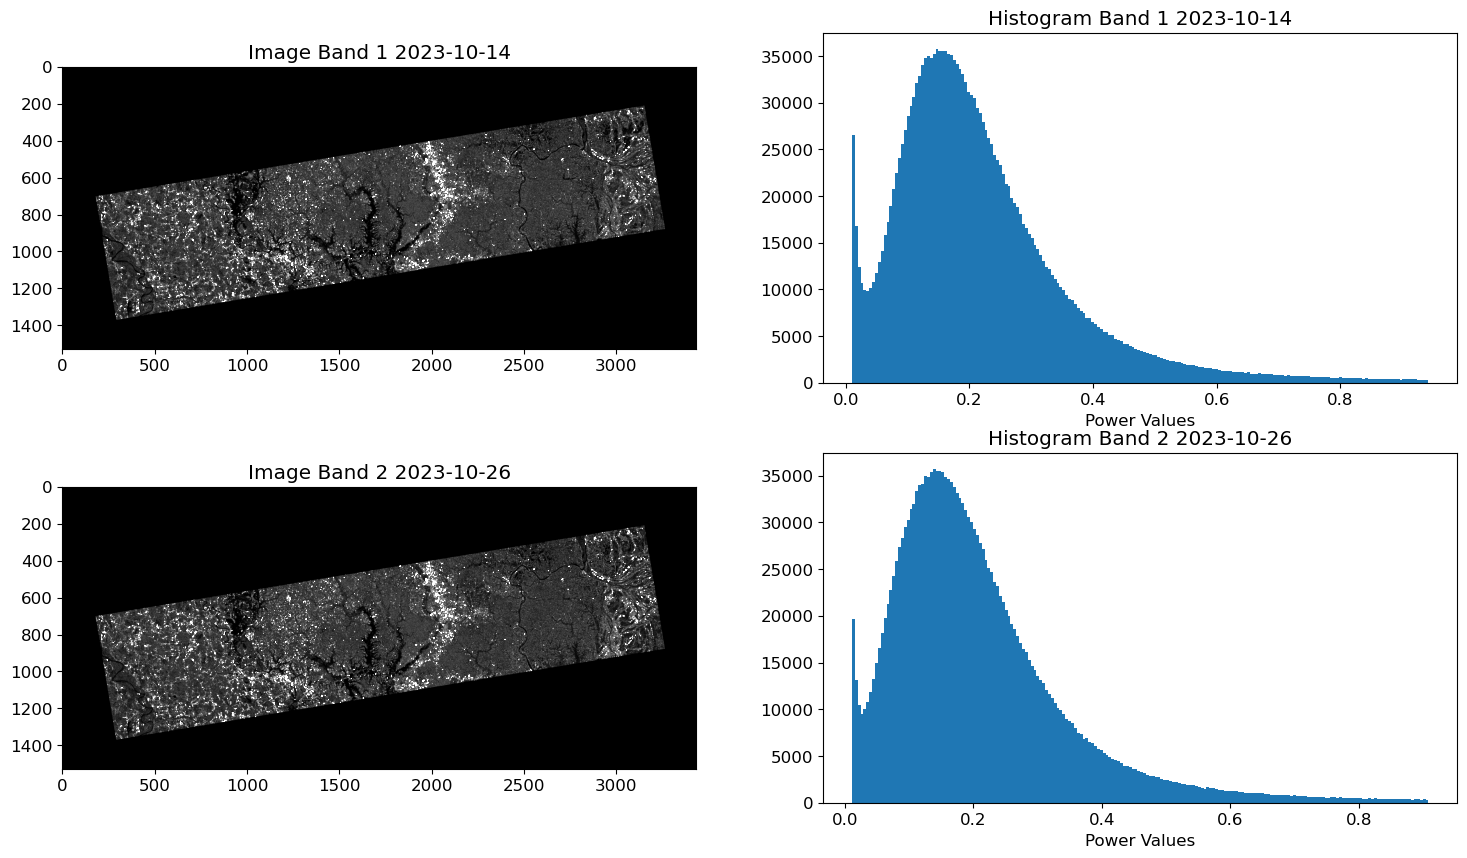

In [18]:
# Setup the pyplot plots
fig = plb.figure(figsize=(18,10)) # Initialize figure with a size
ax1 = fig.add_subplot(221)  # 221 determines: 2 rows, 2 plots, first plot
ax2 = fig.add_subplot(222)  # 222 determines: 2 rows, 2 plots, second plot
ax3 = fig.add_subplot(223)  # 223 determines: 2 rows, 2 plots, third plot
ax4 = fig.add_subplot(224)  # 224 determines: 2 rows, 2 plots, fourth plot

# Plot the band 1 image
band_number = 1
ax1.imshow(raster_1, cmap='gray', vmin=r1_vmin, vmax=r1_vmax) # see note above regarding vmax adjustments
ax1.set_title('Image Band {} {}'.format(band_number, stack_meta['acquisition_date'][band_number-1].date()))

# Flatten the band 1 image into a 1 dimensional vector and plot the histogram:
h = ax2.hist(raster_1.flatten(), bins=200, range=(r1_vmin,r1_vmax))
ax2.xaxis.set_label_text('Power Values')
ax2.set_title('Histogram Band {} {}'.format(band_number, stack_meta['acquisition_date'][band_number-1].date()))

# Plot the band 2 image
band_number = 2
ax3.imshow(raster_2,cmap='gray', vmin=r2_vmin, vmax=r2_vmax) # see note above regarding vmax adjustments
ax3.set_title('Image Band {} {}'.format(band_number, stack_meta['acquisition_date'][band_number-1].date()))

# Flatten the band 2 image into a 1 dimensional vector and plot the histogram:
h = ax4.hist(raster_2.flatten(),bins=200, range=(r2_vmin,r2_vmax))
ax4.xaxis.set_label_text('Power Values')
ax4.set_title('Histogram Band {} {}'.format(band_number, stack_meta['acquisition_date'][band_number-1].date()))

---
### 3.3 Calibration and Data Conversion between dB and Power Scales

**Note, that since we are using OPERA S1-RTC data, this step is not necessary!** 

OPERA performs full data calibration and provides you with data in power scale. If your data is from a different source, calibration may be necessary to ensure that image gray values correspond to proper radar cross section information.

If you must perform calibration and convert to dB scale in the process, **ensure that you convert back to Power scale before proceeding.** While dB-scaled images are often "visually pleasing", they are not a good basis for mathematical operations on data. For instance, when we compute the mean of observations, it makes a difference whether we do that in power or dB scale. Since dB scale is a logarithmic scale, we cannot simply average data in that scale. 





To **convert from dB to power**, apply: $\gamma^o_{pwr} = 10^{\frac{\gamma^o_{dB}}{10}}$

In [19]:
#calPwr=np.power(10.0, rasterstack_dB/10.0)

---
### 3.4 Create a Time Series Animation

Now we are ready to create a time series animation from the calibrated SAR data.

**First, create a raster from band 0 and a raster stack from all the images:**

In [20]:
band = img.GetRasterBand(1)
raster0 = band.ReadAsArray()
band_number = 0 # Needed for updates
rasterstack = img.ReadAsArray()
img = None

**Create and move into a directory in which to store our plots and animations:**

In [21]:
product_path = analysis_dir/f'plots_and_animations'
if not product_path.exists():
    product_path.mkdir()

**Create a masked raster stack:**

In [22]:
rasterstack_masked = np.ma.masked_where(rasterstack==0, rasterstack)

**Generate a matplotlib time-series animation:**

In [23]:
%%capture 
fig = plt.figure(figsize=(14, 8))
ax = fig.subplots()
ax.axis('off')
vmin = np.nanpercentile(rasterstack.flatten(), 5)
vmax = np.nanpercentile(rasterstack.flatten(), 95)

r0dB = 20 * np.log10(raster0) - 83

im = ax.imshow(raster0, cmap='gray', vmin=vmin, vmax=vmax)
ax.set_title("{}".format(stack_meta['acquisition_date'][0].date()))

def animate(i):
    ax.set_title("{}".format(stack_meta['acquisition_date'][i].date()))
    im.set_data(rasterstack[i])

# Interval is given in milliseconds
ani = animation.FuncAnimation(fig, animate, frames=rasterstack.shape[0], interval=400)

**Configure matplotlib's RC settings for the animation:**

In [24]:
rc('animation', embed_limit=40971520.0)

**Create a javascript animation of the time-series running inline in the notebook:**

In [26]:
HTML(ani.to_jshtml())

**Save the animation (animation.gif):**

In [27]:
ani.save(f"{product_path}/animation.gif", writer='pillow', fps=2)

---
### 3.5 Plot the Time Series of Means Calculated Across the Subset

To create the time series of means, we will go through the following steps:
1. Ensure that you use the data in **power scale** ($\gamma^o_{pwr}$) for your mean calculations.
1. compute means.
1. convert the resulting mean values into dB scale for visualization.
1. plot time series of means.

**Compute the means:**

In [28]:
rs_means_pwr = np.nanmean(rasterstack_masked, axis=(1, 2))

**Convert resulting mean value time-series to dB scale for visualization:**

In [29]:
rs_means_dB = 10.*np.log10(rs_means_pwr)

**Plot and save the time series of means (RCSoverTime.png):**

- Use a Savitzky-Golay filter to smooth the data and highlight underlying trends

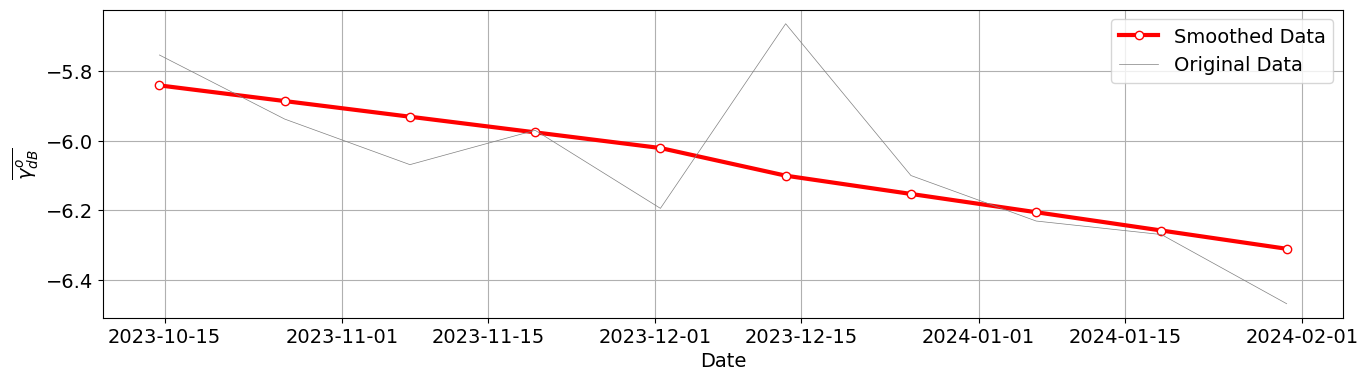

In [30]:
try:
    plt.rcParams.update({'font.size': 14})
    fig = plt.figure(figsize=(16, 4))
    ax1 = fig.subplots()
    window_length = len(rs_means_dB) - 1
    if window_length % 2 == 0:
        window_length -= 1
    polyorder = math.ceil(window_length * 0.1)
    yhat = scipy.signal.savgol_filter(rs_means_dB, window_length, polyorder) 
    # Add smoothed plot
    ax1.plot(stack_meta['acquisition_date'], yhat, color='red', marker='o', markerfacecolor='white', linewidth=3, markersize=6, label='Smoothed Data')
    # Add original plot
    ax1.plot(stack_meta['acquisition_date'], rs_means_dB, color='gray', linewidth=0.5, label='Original Data')
    plt.grid()
    ax1.set_xlabel('Date')
    ax1.set_ylabel(r'$\overline{\gamma^o_{dB}}$')
    # Add the legend to the plot
    ax1.legend()
    plt.savefig(f"{product_path}/RCSoverTime.png", dpi=72, transparent='true')
except ValueError as e:
    print(f"Error: polyorder: {polyorder} >= window_length: {window_length}")
    raise


---
### 3.6 Calculate Coefficient of Variation

The coefficient of variation describes how much the $\sigma_{0}$ or $\gamma_{0}$ measurements in a pixel vary over time. Hence, the coefficient of variation can indicate different vegetation cover and soil moisture regimes in your area.

- The coefficient of variation is the ratio of the standard deviation to the mean (CV = $\frac{\sigma}{\mu}$)
- Useful for combining datasets because the CV is independent of a value's unit. Calculating the CV from differing datasets will provide dimensionless values for comparable results. 

**Write a function to convert our plots into GeoTiffs:**

In [31]:
def geotiff_from_plot(source_image, out_filename, extent, projection, cmap=None, vmin=None, vmax=None, interpolation=None, dpi=300):
    assert "." not in out_filename, 'Error: Do not include the file extension in out_filename'
    assert type(extent) == list and len(extent) == 2 and len(extent[0]) == 2 and len(
        extent[1]) == 2, 'Error: extent must be a list in the form [[upper_left_x, upper_left_y], [lower_right_x, lower_right_y]]'
    
    plt.figure()
    plt.axis('off')
    plt.imshow(source_image, cmap=cmap, vmin=vmin, vmax=vmax, interpolation=interpolation)
    temp = f"{out_filename}_temp.png"
    plt.savefig(temp, dpi=dpi, transparent='true', bbox_inches='tight', pad_inches=0)

    cmd = f"gdal_translate -of Gtiff -a_ullr {extent[0][0]} {extent[0][1]} {extent[1][0]} {extent[1][1]} -a_srs EPSG:{projection} {temp} {out_filename}.tiff"
    !{cmd}
    try:
        Path(temp).unlink()
    except FileNotFoundError:
        pass

**Plot the Coefficient of Variation Map and save it as a png (Coeffvar.png):**

> ***Tip:***
> 
> *You will likely encounter the warning: "RuntimeWarning: Degrees of freedom <= 0 for slice."*
> 
> *This is expected, as some slices around the border of the time series stack will contain only nans.*
> 
> *The warning is safe to ignore.*

/tmp/ipykernel_530/1034443301.py:1: RuntimeWarning: Degrees of freedom <= 0 for slice.
  test = np.nanvar(rasterstack,0)


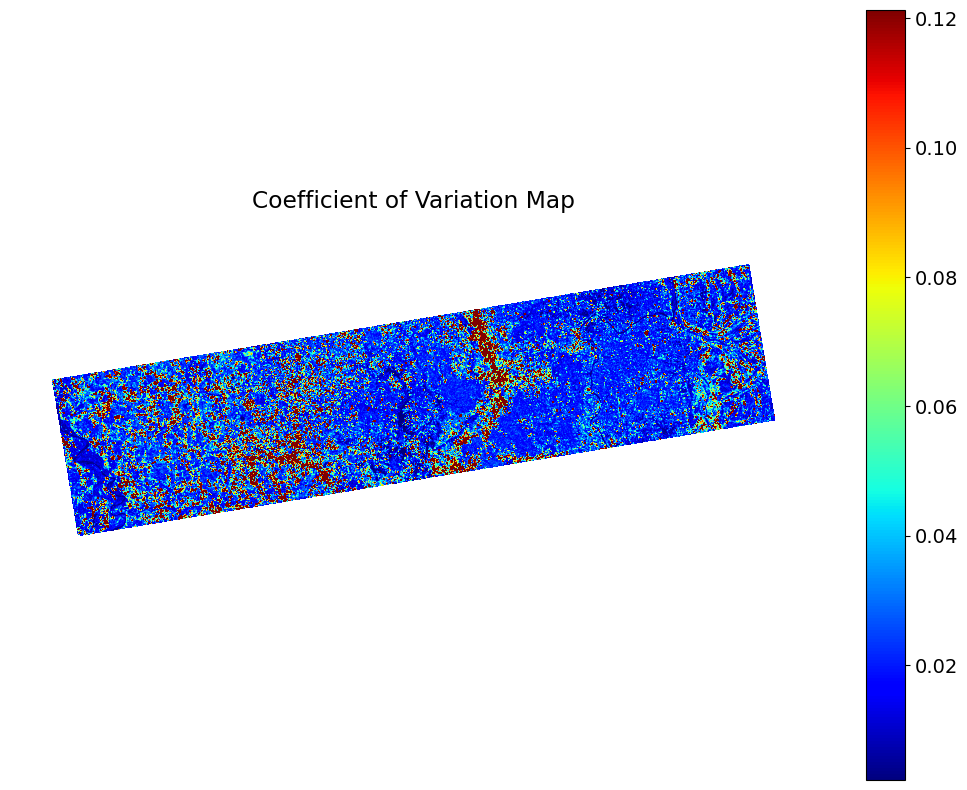

In [32]:
test = np.nanvar(rasterstack,0)
mtest = np.nanmean(rasterstack[rasterstack.nonzero()],0)
# coeffvar = test/(mtest+0.001)
coeffvar = test/(mtest)

plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(13, 10))
ax = fig.subplots()
ax.axis('off')
vmin = np.nanpercentile(coeffvar.flatten(), 5)
vmax = np.nanpercentile(coeffvar.flatten(), 95)
ax.set_title('Coefficient of Variation Map')

im = ax.imshow(coeffvar, cmap='jet', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax)
plt.savefig(f"{product_path}/Coeffvar.png", dpi=300, transparent='true')

**Save the coefficient of variation map as a GeoTiff (Coeffvar.tiff):**

In [33]:
%%capture
geotiff_from_plot(coeffvar, f"{product_path}/Coeffvar", extents, projection, cmap='jet', vmin=vmin, vmax=vmax)

---
### 3.7 Threshold Coefficient of Variation Map

This is an example how to threshold the derived coefficient of variation map. This can be useful, e.g., to detect areas of active agriculture.

**Plot and save the coefficient of variation histogram and CDF (thresh_coeff_var_histogram.png):**

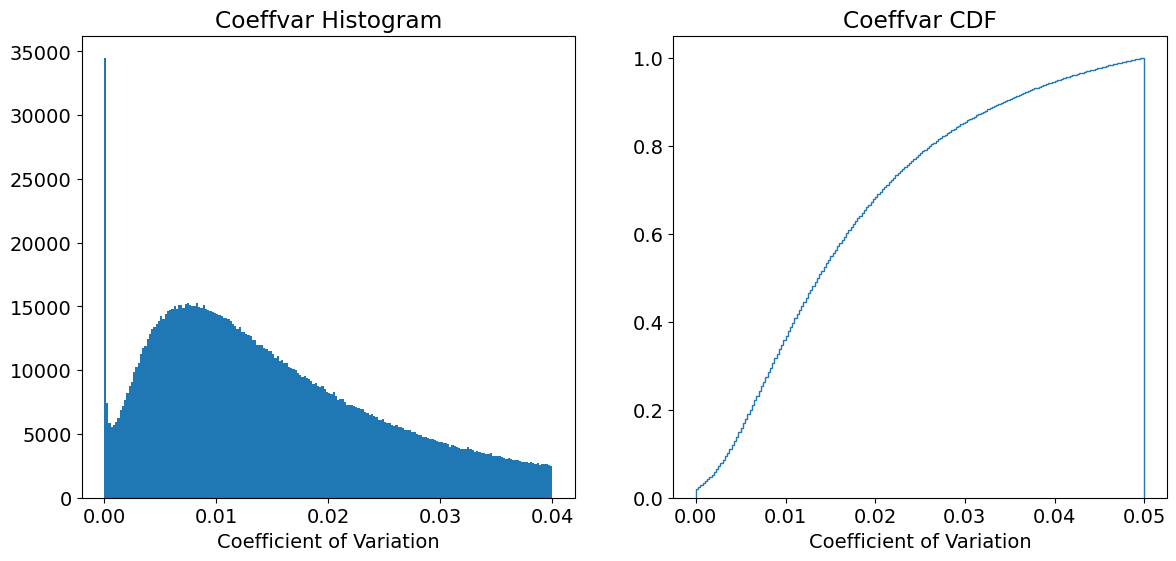

In [34]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(14, 6)) # Initialize figure with a size
ax1 = fig.add_subplot(121)  # 121 determines: 2 rows, 2 plots, first plot
ax2 = fig.add_subplot(122)
# Second plot: Histogram
# IMPORTANT: To get a histogram, we first need to *flatten* 
# the two-dimensional image into a one-dimensional vector.
h = ax1.hist(coeffvar.flatten(), bins=200, range=(0, 0.04))
ax1.xaxis.set_label_text('Coefficient of Variation')
ax1.set_title('Coeffvar Histogram')
plt.grid()
n, bins, patches = ax2.hist(coeffvar.flatten(), bins=200, range=(0, 0.05), cumulative='True', density='True', histtype='step', label='Empirical')
ax2.xaxis.set_label_text('Coefficient of Variation')
ax2.set_title('Coeffvar CDF')
plt.grid()
plt.savefig(f"{product_path}/thresh_coeff_var_histogram.png", dpi=72, transparent='true')

**Plot the Threshold Coefficient of Variation Map and save it as a png (Coeffvarthresh.png):**

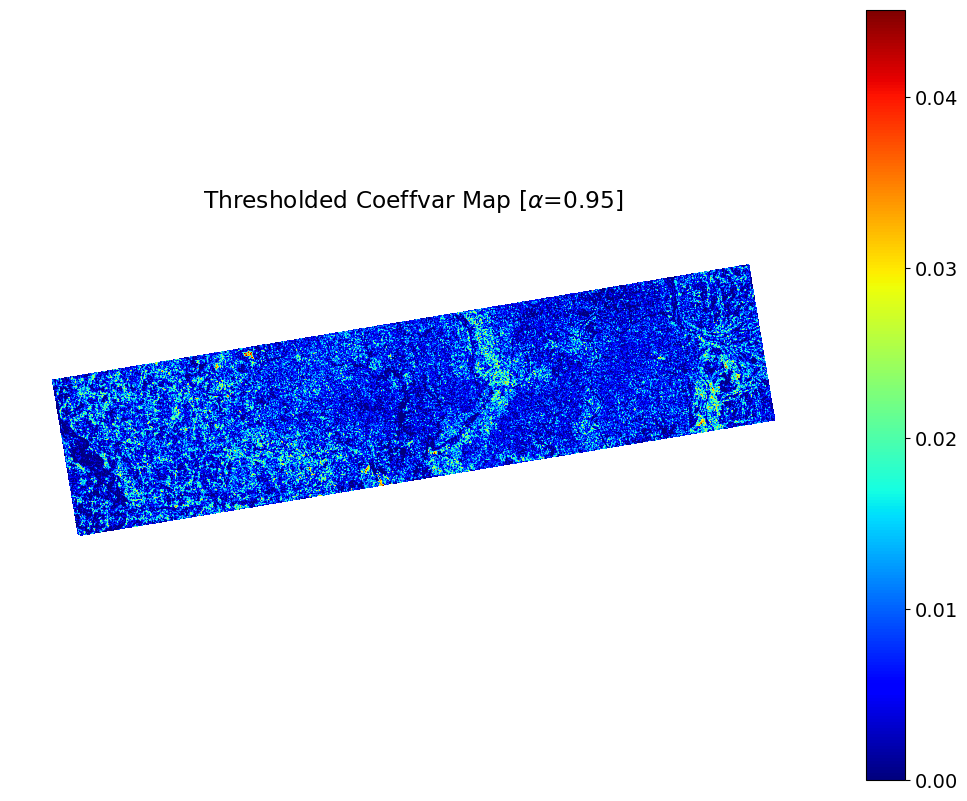

In [35]:
plt.rcParams.update({'font.size': 14})
alpha = 0.95
outind = np.where(n > alpha)
threshind = np.nanmin(outind)
thresh = bins[threshind]
coeffvarthresh = np.copy(coeffvar)
coeffvarthresh[coeffvarthresh < thresh] = 0
coeffvarthresh[coeffvarthresh > 0.1] = 0
fig = plt.figure(figsize=(13, 10))
ax = fig.subplots()
ax.axis('off')
vmin = np.nanpercentile(coeffvarthresh.flatten(), 0)
vmax = np.nanpercentile(coeffvarthresh.flatten(), 90)
ax.set_title(r'Thresholded Coeffvar Map [$\alpha$={}]'.format(alpha))
im = ax.imshow(coeffvarthresh, cmap='jet', vmin=vmin, vmax=vmax)
bar = fig.colorbar(im, ax=ax)
plt.savefig(f"{product_path}/Coeffvarthresh.png", dpi=300, transparent='true')

**Save the Threshold Coefficient of Variation Map as a GeoTiff (Coeffvarthresh.tiff):**

In [36]:
%%capture
geotiff_from_plot(coeffvarthresh, f"{product_path}/Coeffvarthresh", extents, projection, cmap='jet', vmin=vmin, vmax=vmax)

*OPERA-RTC-S1-time_series.ipynb - Version 1.0.0 - January 2024*